In [5]:
import sys
sys.path.append('../')
import os
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from datetime import timedelta
import pickle
import datetime

from utils import utils_scenario as utils, data_preparation as prep, data_process as proc


In [6]:
def get_season(month):
    if month in [12,1,2]:
        return 1
    if month in [3,4,5]:
        return 2
    if month in [6,7,8]:
        return 3
    if month in [9,10,11]:
        return 4

def get_am(hour):
    if hour in range(0,12):
        return 1
    else:
        return 0
    
    
def get_one_forecast(DAY,HOUR):
    forecast_dir_path = main_dir + DAY + '_' + HOUR + '/'
    # Init output
    data = pd.DataFrame()
    # Init f_period
    period_root = 0
    # Read 2 meteo file
    for dir_day in os.listdir(forecast_dir_path):
        if len(dir_day) == 10:
            # load file
            data_per_day = pd.read_csv(forecast_dir_path + dir_day + '/meteo.txt',delimiter=";")
            data_per_day['date'] = dir_day.replace('_','-')
            data_per_day['f_period'] = period_root + data_per_day['heure']
            # append to output
            data = data.append(data_per_day)
            # add 1 day to fperiod
            period_root += 24

    # forecast date
    data['f_date'] = data['date'] + ' ' 
    data['f_date'] += data['heure'].map(lambda x : str(x).zfill(2))
    data['f_date'] += ':00:00'
    # present date
    data['p_date'] = DAY.replace('_','-') + ' ' + HOUR + ':00:00'

    # rename columns 
    data = data.rename(columns={'vitesse' : 'speed', 
                                'temperature' : 'temp', 
                                'rayonnement' : 'rad',
                                'direction' : 'wind_dir'})

    # compute cos and sin
    data['cos_wind_dir'] = np.cos(2 * np.pi * data['wind_dir'] / 360)
    data['sin_wind_dir'] = np.sin(2 * np.pi * data['wind_dir'] / 360)

    # select columns
    data = data[['p_date','f_date','speed','temp','rad','precip','cos_wind_dir','sin_wind_dir','wind_dir']]
    return data

### 1. Process Raw

In [7]:
#read daily measurement files
main_dir =  './data/raw/daily_measurement/'
measurement = pd.DataFrame()

#get the list of files:
for file_path in os.listdir(main_dir):
    measurement = measurement.append(pd.read_csv(main_dir + file_path))
    
measurement = measurement.reset_index(drop=True)

# Date format
measurement['datetime'] = pd.to_datetime(measurement['datetime'],format='%Y-%m-%d %H:%M:%S')

# Drop na
measurement = measurement.set_index('datetime') \
              [['speed','temp', 'radiation', 'precip','wind_dir']] \
              .dropna(axis=0, how='all')
# Smooth wind direction 
measurement = prep.smooth_wind_dir(measurement)

# Init output measurement data
measurement_out = pd.DataFrame()
# Speed weighted hourly mean for sin & cos
measurement_out['cos_wind_dir'] = (measurement['cos_wind_dir'] * measurement['speed']).resample('H', label='right').sum() \
                                                   / measurement['speed'].resample('H', label='right').sum()
# Speed weighted hourly mean for sin & cos
measurement_out['sin_wind_dir'] = (measurement['sin_wind_dir'] * measurement['speed']).resample('H', label='right').sum() \
                                                   / measurement['speed'].resample('H', label='right').sum()

# Hourly mean for speed, temperature, radiation and precipitation
for col in ['speed','temp','radiation','precip']:
    measurement_out[col] = measurement[col].resample('1H', label='right').mean()
 
 #add caterogical features
measurement_out['season'] = measurement_out.index.month.map(get_season) # ordinal not categorical for linear models
measurement_out['am'] = measurement_out.index.hour.map(get_am)

measurement_out = measurement_out.reset_index()
# Add 1 hour to data because of hourly mean : data between 1am and 2am will be available at 2am
#measurement_out['datetime'] = measurement_out['datetime'] + datetime.timedelta(hours=1)

# Select columns
measurement_out = measurement_out[['datetime','speed','cos_wind_dir','sin_wind_dir','temp','radiation','precip','season']] #'am' feature is not currently in the model

smooth wind direction


In [8]:
#check if any col is missing
measurement_cols = pickle.load(open('measurement_cols.pkl', 'rb'))
print('checking missing columns are: ', (measurement_cols).difference(measurement_out.columns))

checking missing columns are:  Index([], dtype='object')


In [9]:
#save to processed 
measurement_out.to_csv('./data/processed_mit/last_measurement.csv',index=False)

In [10]:
#check for safi processed
measurement_safi = pd.read_csv('./data/processed_safi/last_measurement.csv')

measurement_mit = pd.read_csv('./data/processed_mit/last_measurement.csv')

In [11]:
#find intersect based on datetime
intersect = set(measurement_mit['datetime']).intersection(set(measurement_safi['datetime']))
df_mit= measurement_mit.loc[measurement_mit['datetime'].isin(intersect)]
df_safi= measurement_safi.loc[measurement_safi['datetime'].isin(intersect)]

#round columns to 2 decimal places for comparison 
for col in [ 'speed', 'cos_wind_dir', 'sin_wind_dir', 'temp',
       'radiation', 'precip',]:
    df_safi[col]= df_safi[col].round(2)
    df_mit[col] = df_mit[col].round(2)
    
#find the rows of different entries, by concatenating below and drop duplicates
differences = pd.concat([df_safi,df_mit], keys=['safi', 'mit']).drop_duplicates(keep=False)
#print the places where values are different 
pd.merge(differences.loc['safi'],differences.loc['mit'], on ='datetime', suffixes=('_safi', '_mit'))

,datetime,speed_safi,cos_wind_dir_safi,sin_wind_dir_safi,temp_safi,radiation_safi,precip_safi,season_safi,speed_mit,cos_wind_dir_mit,sin_wind_dir_mit,temp_mit,radiation_mit,precip_mit,season_mit
0,2020-08-17 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3,6.31,0.86,0.38,28.20,0.00,0.0,3
1,2020-08-22 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3,6.23,0.52,0.81,26.62,152.43,0.0,3
2,2020-08-22 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3,7.27,0.41,0.88,28.96,573.36,0.0,3
3,2020-08-23 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3,3.49,0.42,0.88,25.33,22.12,0.0,3
4,2020-08-23 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3,5.55,0.43,0.87,27.36,284.33,0.0,3
5,2020-08-27 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3,4.03,0.69,0.65,36.26,436.55,0.0,3
6,2020-08-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3,3.36,0.64,0.73,30.47,0.00,0.0,3
7,2020-08-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3,4.61,0.72,0.64,25.90,0.00,0.0,3
8,2020-08-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3,5.11,0.39,0.90,31.07,0.02,0.0,3
9,2020-09-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,4,3.75,0.66,0.68,25.90,0.00,0.0,4


### 2. Get Forecast

In [12]:
main_dir = './data/raw/forecast/'
sub_dir = os.listdir(main_dir)

# concat files
forecast = pd.DataFrame()
for file_path in sub_dir:
    DAY = file_path[0:10]
    HOUR = file_path[11:13]
    forecast = forecast.append(get_one_forecast(DAY,HOUR))
forecast = forecast.reset_index(drop=True)
display(forecast.head())

,p_date,f_date,speed,temp,rad,precip,cos_wind_dir,sin_wind_dir,wind_dir
0,2020-07-01 00:00:00,2020-07-01 00:00:00,4.0,20.8,0,0.0,0.731354,0.681998,43
1,2020-07-01 00:00:00,2020-07-01 01:00:00,3.8,20.2,0,0.0,0.694658,0.719340,46
2,2020-07-01 00:00:00,2020-07-01 02:00:00,3.8,19.9,0,0.0,0.669131,0.743145,48
3,2020-07-01 00:00:00,2020-07-01 03:00:00,4.0,19.8,0,0.0,0.615661,0.788011,52
4,2020-07-01 00:00:00,2020-07-01 04:00:00,4.1,19.6,0,0.0,0.559193,0.829038,56


In [13]:
#change to dt 
forecast['f_date']= pd.to_datetime(forecast['f_date'],format='%Y-%m-%d %H:%M:%S')
forecast['p_date']= pd.to_datetime(forecast['p_date'],format='%Y-%m-%d %H:%M:%S')

#calculate forecast period (f_period)
forecast['f_period'] =forecast['f_date'] - forecast['p_date']
forecast['f_period'] = forecast['f_period'].dt.components['hours']+forecast['f_period'].dt.components['days']*24

#crop out <=6 hours 
forecast = forecast.loc[forecast['f_period']>=6]
forecast= prep.keep_last_forecast(forecast)
forecast.reset_index(inplace=True)

In [14]:
#read pickle format columns 
forecast_cols = pickle.load(open('forecast_cols.pkl', 'rb'))
print('checking missing columns are: ', (forecast_cols).difference(forecast.columns))

checking missing columns are:  Index([], dtype='object')


In [15]:
forecast.to_csv('./data/processed_mit/last_forecast.csv',index=False)

In [16]:
#check for safi processed
df_safi = pd.read_csv('./data/processed_safi/last_forecast.csv')
df_mit = pd.read_csv('./data/processed_mit/last_forecast.csv')

#find intersect based on datetime
intersect = set(df_safi['f_date']).intersection(set(df_mit['f_date']))
df_mit= measurement_mit.loc[df_mit['f_date'].isin(intersect)]
df_safi= measurement_safi.loc[df_safi['f_date'].isin(intersect)]


#round columns to 2 decimal places for comparison 
for col in [ 'speed', 'cos_wind_dir', 'sin_wind_dir', 'temp',
       'radiation', 'precip',]:
    df_safi[col]= df_safi[col].round(2)
    df_mit[col] = df_mit[col].round(2)
    
#find the rows of different entries, by concatenating below and drop duplicates
differences = pd.concat([df_safi,df_mit], keys=['safi', 'mit']).drop_duplicates(keep=False)
#print the places where values are different 
pd.merge(differences.loc['safi'],differences.loc['mit'], on ='datetime', suffixes=('_safi', '_mit'))

,datetime,speed_safi,cos_wind_dir_safi,sin_wind_dir_safi,temp_safi,radiation_safi,precip_safi,season_safi,speed_mit,cos_wind_dir_mit,sin_wind_dir_mit,temp_mit,radiation_mit,precip_mit,season_mit
0,2020-08-17 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3,6.31,0.86,0.38,28.20,0.00,0.0,3
1,2020-08-22 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3,6.23,0.52,0.81,26.62,152.43,0.0,3
2,2020-08-22 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3,7.27,0.41,0.88,28.96,573.36,0.0,3
3,2020-08-23 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3,3.49,0.42,0.88,25.33,22.12,0.0,3
4,2020-08-23 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3,5.55,0.43,0.87,27.36,284.33,0.0,3
5,2020-08-27 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3,4.03,0.69,0.65,36.26,436.55,0.0,3
6,2020-08-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3,3.36,0.64,0.73,30.47,0.00,0.0,3
7,2020-08-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3,4.61,0.72,0.64,25.90,0.00,0.0,3
8,2020-08-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3,5.11,0.39,0.90,31.07,0.02,0.0,3
9,2020-09-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,4,3.75,0.66,0.68,25.90,0.00,0.0,4


### 3. Make Prediction

In [17]:
#read in processed measurement data and forecast data
measurement = pd.read_csv('./data/processed_mit/last_measurement.csv')
measurement['datetime']= pd.to_datetime(measurement['datetime'],format='%Y-%m-%d %H:%M:%S')
forecast = pd.read_csv('./data/processed_mit/last_forecast.csv')
forecast['f_date']= pd.to_datetime(forecast['f_date'],format='%Y-%m-%d %H:%M:%S')


In [18]:
#prepare processed data into same format as training df 
def prepare_x_test(measurement, forecast, past_n_steps, pred_period):
    
    #concat past n steps from measurement 
    df = measurement.set_index('datetime')
    #drop am feature
#     df = df.drop(['am'], axis=1)
    df=proc.get_past_n_steps(df, past_n_steps)
    #calculate forecast_time
    df['forecast_time'] = df['present_time']+timedelta(hours=pred_period)

    #join forecast according to forecast time 
    forecast = forecast.set_index('f_date') 
    forecast = forecast.add_suffix('_forecast')
    df = pd.merge(df, forecast, how = 'left', left_on = 'forecast_time', right_on ='f_date')
    #add cos day
    df = proc.smooth_day_hour(df)
    #fillna
    df.fillna(value=0, inplace=True)
    df = df.iloc[:-past_n_steps]
    #keep the present_time information 
#     df_out = df.loc[df['present_time']]
    return df 

In [19]:
#check if any col is missing 
df= prepare_x_test(measurement, forecast, 48, 6)
#load model columns 
model_cols = pickle.load(open('model_cols_past_48.pkl', 'rb'))
print('columns missing:', model_cols.difference(df.columns))

columns missing: Index([], dtype='object')


In [20]:
df

,speed_t-48,cos_wind_dir_t-48,sin_wind_dir_t-48,temp_t-48,radiation_t-48,precip_t-48,season_t-48,speed_t-47,cos_wind_dir_t-47,sin_wind_dir_t-47,...,forecast_time,speed_forecast,temp_forecast,rad_forecast,precip_forecast,cos_wind_dir_forecast,sin_wind_dir_forecast,wind_dir_forecast,cos_day,cos_hour
0,3.523333,0.419934,0.878093,24.590000,0.000000,0.0,3,3.715000,0.451142,0.845504,...,2020-07-03 07:00:00,5.4,20.8,136.0,0.0,0.573576,0.819152,55.0,0.998667,0.965926
1,3.715000,0.451142,0.845504,24.340000,0.000000,0.0,3,2.500000,0.758071,0.584625,...,2020-07-03 08:00:00,5.1,22.3,333.0,0.0,0.573576,0.819152,55.0,0.998667,0.866025
2,2.500000,0.758071,0.584625,23.993333,0.000000,0.0,3,3.043333,0.760389,0.600481,...,2020-07-03 09:00:00,4.8,24.5,522.0,0.0,0.656059,0.754710,49.0,0.998667,0.707107
3,3.043333,0.760389,0.600481,23.605000,0.000000,0.0,3,4.423333,0.595837,0.763091,...,2020-07-03 10:00:00,4.9,27.0,694.0,0.0,0.766044,0.642788,40.0,0.998667,0.500000
4,4.423333,0.595837,0.763091,23.580000,0.000000,0.0,3,4.371667,0.525243,0.808122,...,2020-07-03 11:00:00,5.2,29.1,824.0,0.0,0.857167,0.515038,31.0,0.998667,0.258819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1620,3.391667,0.261862,-0.908845,26.136667,704.300000,0.0,4,5.553333,0.495163,-0.827178,...,2020-09-08 19:00:00,4.3,26.4,37.0,0.0,0.829038,0.559193,34.0,0.990532,-0.965926
1621,5.553333,0.495163,-0.827178,24.723333,747.550000,0.0,4,6.021667,0.590844,-0.778296,...,2020-09-08 20:00:00,4.1,25.1,0.0,0.0,0.707107,0.707107,45.0,0.990532,-0.866025
1622,6.021667,0.590844,-0.778296,24.750000,730.983333,0.0,4,6.076667,0.516065,-0.827502,...,2020-09-08 21:00:00,4.0,24.2,0.0,0.0,0.629320,0.777146,51.0,0.990532,-0.707107
1623,6.076667,0.516065,-0.827502,25.613333,658.566667,0.0,4,4.230000,0.327261,-0.912090,...,2020-09-08 22:00:00,4.0,23.7,0.0,0.0,0.573576,0.819152,55.0,0.990532,-0.500000


In [21]:
predict_list = np.arange(1,49,1) 
#predict result for all hours 
predict_all = pd.DataFrame() 
for pred in predict_list:
    #predict result for one hour
    predict = pd.DataFrame(columns={'present_time','forecast_time','speed','cos_wind_dir','sin_wind_dir'})
    x_test = prepare_x_test(measurement, forecast, 48, int(pred))
    #drop timestamp columns and change to array format
    predict['forecast_time'] = x_test['forecast_time']
    predict['present_time']= x_test['present_time'] 
    
    x_test = x_test.drop(['present_time','forecast_time'], axis=1)

    #check missing features 
    xgb1 = pickle.load(open('../trained_models/speed_t_'+str(pred), 'rb'))
    model_features = xgb1.get_booster().feature_names
    missing_features = set(model_features).difference(x_test.columns)
    if len(missing_features)>=1:
        print('model not run because some features are missing:', missing_features)
        break 
    else:
        #re-order features 
        x_test = x_test[model_features]

    #read 3 models for speed, cos_wind, sin_wind
    xgb1= pickle.load(open('../trained_models/speed_t_'+str(pred), 'rb'))
    xgb2 = pickle.load(open('../trained_models/cos_wind_dir_t_'+str(pred), 'rb'))
    xgb3 = pickle.load(open('../trained_models/sin_wind_dir_t_'+str(pred), 'rb'))

    #predict 
    predict['speed'] = xgb1.predict(x_test)
    predict['cos_wind_dir'] = xgb2.predict(x_test)
    predict['sin_wind_dir'] = xgb3.predict(x_test)
    
    #calculate wind_dir
    predict['wind_dir'] = predict.apply(lambda row: utils.get_angle_in_degree(row['cos_wind_dir'],row['sin_wind_dir']),axis = 1)
    
    predict_all=predict_all.append(predict)

cos and sin out of range, returned 0
cos and sin out of range, returned 0


In [22]:
#sort values:
predict_all.sort_values(['present_time','forecast_time'])

,cos_wind_dir,present_time,sin_wind_dir,forecast_time,speed,wind_dir
0,0.570812,2020-07-03 01:00:00,0.787431,2020-07-03 02:00:00,4.530255,55.193124
0,0.626411,2020-07-03 01:00:00,0.759820,2020-07-03 03:00:00,4.232328,51.214150
0,0.544751,2020-07-03 01:00:00,0.755041,2020-07-03 04:00:00,4.278272,56.992347
0,0.567933,2020-07-03 01:00:00,0.759494,2020-07-03 05:00:00,4.264928,55.393810
0,0.623850,2020-07-03 01:00:00,0.783610,2020-07-03 06:00:00,5.121743,51.402136
...,...,...,...,...,...,...
1624,0.544020,2020-09-08 17:00:00,-0.187459,2020-09-10 13:00:00,3.607264,302.957703
1624,0.488939,2020-09-08 17:00:00,-0.304560,2020-09-10 14:00:00,4.234135,299.270843
1624,0.746732,2020-09-08 17:00:00,-0.146733,2020-09-10 15:00:00,5.345250,318.308055
1624,0.741113,2020-09-08 17:00:00,-0.252084,2020-09-10 16:00:00,4.659088,317.826318


In [23]:
predict_all.to_csv('./data/results_mit/all_results.csv',index=False)

In [24]:
#load all prediction results from safi 
main_dir =  './data/results_safi/'
predict_safi = pd.DataFrame()
#get the list of files:
for file_path in os.listdir(main_dir):
    predict_safi = predict_safi.append(pd.read_csv(main_dir + file_path))  
predict_safi = predict_safi.reset_index(drop=True)

In [25]:
predict_mit = pd.read_csv('./data/results_mit/all_results.csv')

In [26]:
# #check for differences 
df_safi = predict_safi.copy()
df_mit = predict_mit.copy()

# #find intersect based on datetime
intersect = set(df_safi['forecast_time']).intersection(set(df_mit['forecast_time']))
df_mit= df_mit.loc[df_mit['forecast_time'].isin(intersect)]
df_safi= df_safi.loc[df_safi['forecast_time'].isin(intersect)]


#round columns to 2 decimal places for comparison 
for col in [ 'speed', 'cos_wind_dir', 'sin_wind_dir','wind_dir']:
    df_safi[col]= df_safi[col].round(2)
    df_mit[col] = df_mit[col].round(2)
    
#find the rows of different entries, by concatenating below and drop duplicates
differences = pd.concat([df_safi,df_mit], keys=['safi', 'mit']).drop_duplicates(keep=False)
#print the places where values are different 
pd.merge(differences.loc['safi'],differences.loc['mit'], on =['forecast_time','present_time'], suffixes=('_safi', '_mit'))

,cos_wind_dir_safi,forecast_time,present_time,sin_wind_dir_safi,speed_safi,wind_dir_safi,cos_wind_dir_mit,sin_wind_dir_mit,speed_mit,wind_dir_mit
0,0.84,2020-07-28 14:00:00,2020-07-28 13:00:00,-0.06,6.02,213.15,0.84,-0.06,6.02,326.85
1,0.88,2020-07-28 15:00:00,2020-07-28 13:00:00,-0.42,7.37,208.29,0.88,-0.42,7.37,331.71
2,0.87,2020-07-28 16:00:00,2020-07-28 13:00:00,-0.52,6.95,209.54,0.87,-0.52,6.95,330.46
3,0.85,2020-07-28 17:00:00,2020-07-28 13:00:00,-0.51,5.74,211.81,0.85,-0.51,5.74,328.19
4,0.88,2020-07-28 18:00:00,2020-07-28 13:00:00,-0.37,5.39,208.60,0.88,-0.46,5.16,331.40
...,...,...,...,...,...,...,...,...,...,...
41685,0.50,2020-09-10 12:00:00,2020-09-08 16:00:00,-0.23,2.91,240.13,0.52,-0.14,3.03,301.43
41686,0.42,2020-09-10 13:00:00,2020-09-08 16:00:00,0.09,3.97,65.12,0.54,-0.05,4.00,302.65
41687,0.72,2020-09-10 14:00:00,2020-09-08 16:00:00,-0.33,4.40,224.26,0.63,-0.28,4.42,309.33
41688,0.65,2020-09-10 15:00:00,2020-09-08 16:00:00,-0.30,5.10,229.21,0.66,-0.32,5.43,310.94


### Check Performance

In [27]:
measurement = pd.read_csv('./data/processed_mit/last_measurement.csv')
measurement['datetime'] = pd.to_datetime(measurement['datetime'],format='%Y-%m-%d %H:%M:%S')
measurement = measurement.dropna()
#calculate wind_dir
measurement['wind_dir'] = measurement.apply(lambda row: utils.get_angle_in_degree(row['cos_wind_dir'],row['sin_wind_dir']),axis = 1)
    
predict_mit = pd.read_csv('./data/results_mit/all_results.csv')
# Date format
predict_mit['present_time'] = pd.to_datetime(predict_mit['present_time'],format='%Y-%m-%d %H:%M:%S')
predict_mit['forecast_time'] = pd.to_datetime(predict_mit['forecast_time'],format='%Y-%m-%d %H:%M:%S')
#calculate prediction period 
predict_mit['f_period'] = (predict_mit['forecast_time'] - predict_mit['present_time'])/np.timedelta64(1, 'h')

In [28]:
#load all prediction results from safi 
main_dir =  './data/results_safi/'
predict_safi = pd.DataFrame()
#get the list of files:
for file_path in os.listdir(main_dir):
    predict_safi = predict_safi.append(pd.read_csv(main_dir + file_path))  
predict_safi = predict_safi.reset_index(drop=True)
# Date format
predict_safi['present_time'] = pd.to_datetime(predict_safi['present_time'],format='%Y-%m-%d %H:%M:%S')
predict_safi['forecast_time'] = pd.to_datetime(predict_safi['forecast_time'],format='%Y-%m-%d %H:%M:%S')
#calculate prediction period 
predict_safi['f_period'] = (predict_safi['forecast_time'] - predict_safi['present_time'])/np.timedelta64(1, 'h')

In [29]:
#load official forecast - taking last forecasts  
forecast= pd.read_csv('./data/processed_mit/last_forecast.csv')
forecast['f_date'] = pd.to_datetime(forecast['f_date'],format='%Y-%m-%d %H:%M:%S')

In [54]:
# define a function to calculate the error of angles: taking into account of cyclical nature 
# error for a pair of angles 
def angle_diff(a1, a2):
    if abs(a1-a2) <= 180:
        mae = abs(a1-a2)
    else:
        mae = 360 - abs(a1-a2)
    return mae 
# mae applied to series 
def angle_mae(df, col1, col2):
    error= df.apply(lambda row: angle_diff(row[col1],row[col2]),axis = 1)
    return error.mean()


In [51]:
from sklearn import metrics
predict_list = np.arange(1,49,1) 
#predict result for all hours 
accuracy = pd.DataFrame() 
#get 1 hour prediction accuracy:
for pred  in predict_list: 
    df_mit= predict_mit.loc[predict_mit['f_period']==pred]
    df_safi= predict_safi.loc[predict_safi['f_period']==pred]
    predict_merge= pd.merge(df_mit, df_safi, how = 'inner', on = 'forecast_time', suffixes=('_mit','_safi'))

    df_merge= pd.merge(measurement, predict_merge, how = 'inner', 
                       left_on = 'datetime', right_on = 'forecast_time', 
                       suffixes=('_real','_predict'))
    df_merge = pd.merge(df_merge, forecast, how = 'left', 
                        left_on = 'datetime', right_on = 'f_date',
                       suffixes=('','_ofcl'))
    df_merge = df_merge.reset_index(drop=True)

    speed_mae_mit = metrics.mean_absolute_error(df_merge['speed'], df_merge['speed_mit'])
    angle_mae_mit =angle_mae(df_merge,'wind_dir', 'wind_dir_mit')
    speed_mae_safi = metrics.mean_absolute_error(df_merge['speed'], df_merge['speed_safi'])
    angle_mae_safi = angle_mae(df_merge,'wind_dir', 'wind_dir_safi')
    speed_mae_ofcl = metrics.mean_absolute_error(df_merge['speed'], df_merge['speed_ofcl'])
    angle_mae_ofcl = angle_mae(df_merge,'wind_dir', 'wind_dir_ofcl')
    
    #record accuracy
    accuracy = accuracy.append({'pred_n_steps': str(pred),
                                'speed_mae_mit': speed_mae_mit,
                                'speed_mae_safi': speed_mae_safi,
                                'angle_mae_mit': angle_mae_mit,
                                'angle_mae_safi': angle_mae_safi,
                                'speed_mae_ofcl': speed_mae_ofcl,
                                'angle_mae_ofcl': angle_mae_ofcl
                               }, ignore_index=True)  
accuracy   

,angle_mae_mit,angle_mae_ofcl,angle_mae_safi,pred_n_steps,speed_mae_mit,speed_mae_ofcl,speed_mae_safi
0,10.192455,23.317785,35.465755,1,0.497315,0.872871,0.506676
1,13.502174,23.653152,36.566313,2,0.651937,0.873701,0.660972
2,15.499870,23.665275,36.857641,3,0.712636,0.870446,0.718792
3,17.129955,23.764140,38.440899,4,0.750786,0.871919,0.757491
4,17.164012,23.610104,37.383724,5,0.757148,0.872334,0.767237
5,18.867133,23.787429,39.504530,6,0.737317,0.876610,0.747268
6,17.950934,24.119187,38.868659,7,0.733014,0.885545,0.748960
7,18.861742,24.356042,39.190483,8,0.756075,0.881241,0.757495
8,18.585990,23.942768,38.416418,9,0.751124,0.867375,0.750887
9,18.722881,23.476440,37.979798,10,0.797227,0.872300,0.814768


Text(0, 0.5, 'MAE (km/h)')

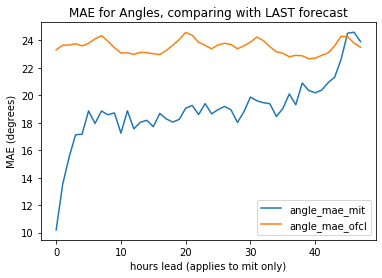

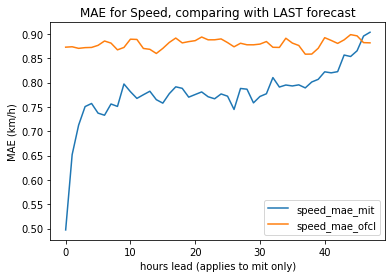

In [55]:
#plots 
ax = accuracy[['angle_mae_mit','angle_mae_ofcl']].plot(title='MAE for Angles, comparing with LAST forecast')
ax.set_xlabel("hours lead (applies to mit only)")
ax.set_ylabel("MAE (degrees)")

ax = accuracy[['speed_mae_mit','speed_mae_ofcl']].plot(title='MAE for Speed, comparing with LAST forecast')
ax.set_xlabel("hours lead (applies to mit only)")
ax.set_ylabel("MAE (km/h)")

In [53]:
#save to csv 
accuracy.to_csv('accuracy_comparison.csv', index=False)